In [1]:
#Import tensorflow and checking the versions
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
#Install dependencies

!pip install kaggle

In [3]:
!pwd 

/content


In [4]:
!mkdir -p ~/.kaggle
!cp '/kaggle.json' ~/.kaggle/

#Changing permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#Download Dataset
!kaggle competitions download -c digit-recognizer

 55% 5.00M/9.16M [00:00<00:00, 6.32MB/s]
100% 9.16M/9.16M [00:00<00:00, 11.1MB/s]
 82% 5.00M/6.09M [00:00<00:00, 28.9MB/s]
100% 6.09M/6.09M [00:00<00:00, 29.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 72.7MB/s]


In [6]:
!unzip 'train.csv.zip' 
!unzip 'test.csv.zip'

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [7]:
!rm -rf test.csv.zip

!rm -rf train.csv.zip

#Importing Packages

In [8]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-bright')

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Reading & Reshaping the Dataset

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
print('Train Data Shape: {}'.format(train.shape))
print('Test Data Shape: {}'.format(test.shape))

Train Data Shape: (42000, 785)
Test Data Shape: (28000, 784)


In [11]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Label Samples Distribution

Text(0, 0.5, 'Count')

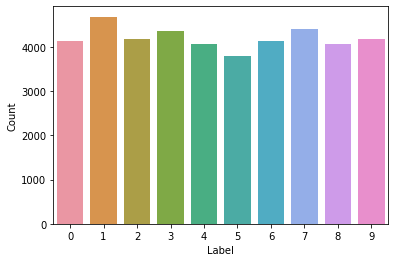

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(train['label'])
plt.xlabel('Label')
plt.ylabel('Count')

In [13]:
Y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')

print(X_train.shape, Y_train.shape, X_test.shape)

(42000, 784) (42000,) (28000, 784)


#### Reshaping the Data

In [14]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_train = X_train / 255.0

X_test = X_test.values.reshape(-1, 28, 28, 1)
X_test = X_test / 255.0

print(X_train.shape, X_test.shape)

(42000, 28, 28, 1) (28000, 28, 28, 1)


#### One Hot Encoding Target Values

In [15]:
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_train.shape

(42000, 10)

##### Here is the comparison between standard and encoded values

In [16]:
train['label'].head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [18]:
Y_train[0:5, :]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Defining Modeling

In [19]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu', padding='Same'), 
    Conv2D(64, (3, 3), activation='relu', padding='Same'), 
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), 
    Dropout(0.25), 
    Conv2D(64, (3, 3), activation='relu', padding='Same'), 
    Conv2D(64, (3, 3), activation='relu', padding='Same'), 
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25), 
    Flatten(), 
    Dense(256, activation='relu'), 
    Dense(256, activation='relu'), 
    Dropout(0.50), 
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0

##### Callback Class to stop Fitting at an accuracy of 0.999

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def end_if(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.999):
            print('Reached 0.999 accuracy so cancelling Training')
            self.model.stop_training = True
            
callbacks = myCallback()

#### Fitting the model

In [21]:
Optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.0005, 
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-07, 
                    name='Adam')

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=50, epochs=20, callbacks=[callbacks])

Epoch 1/20
840/840 [==============================] - 43s 16ms/step - loss: 0.3287 - accuracy: 0.8910
Epoch 2/20
840/840 [==============================] - 12s 14ms/step - loss: 0.0840 - accuracy: 0.9758
Epoch 3/20
840/840 [==============================] - 12s 14ms/step - loss: 0.0589 - accuracy: 0.9824
Epoch 4/20
840/840 [==============================] - 12s 14ms/step - loss: 0.0478 - accuracy: 0.9857
Epoch 5/20
840/840 [==============================] - 12s 14ms/step - loss: 0.0412 - accuracy: 0.9881
Epoch 6/20
840/840 [==============================] - 12s 14ms/step - loss: 0.0359 - accuracy: 0.9893
Epoch 7/20
840/840 [==============================] - 11s 13ms/step - loss: 0.0311 - accuracy: 0.9905
Epoch 8/20
840/840 [==============================] - 11s 13ms/step - loss: 0.0280 - accuracy: 0.9920
Epoch 9/20
840/840 [==============================] - 11s 13ms/step - loss: 0.0250 - accuracy: 0.9923
Epoch 10/20
840/840 [==============================] - 11s 13ms/step - loss: 0.023

In [22]:
pred = model.predict(X_test)

#select the index with the maximum probability
pred = np.argmax(pred, axis=1)

pred = pd.Series(pred, name='Label')

In [23]:
submission = pd.concat([pd.Series(range(1, 28001), name='ImageID'), pred], axis=1)
submission.to_csv('submission.csv', index=False)

submission.head(10)

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [24]:
#Submission of Results
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"

100% 208k/208k [00:03<00:00, 62.2kB/s]
Successfully submitted to Digit Recognizer